### General rules:
 * Replace *Template* by your *FirstnameLastname* in the filename before submitting the solution.
 * For all figures that you generate, remember to add meaningful labels to the axes, and make a legend, if applicable.
 * Do not hard code constants, like number of samples, number of channels, etc in your program. These values should always be determined from the given data. This way, you can easily use the code to analyse other data sets.
 * Do not use high-level functions from toolboxes like scikit-learn.

# AAND - BCI Exercise Sheet #01

#### Name: Bramantyo Supriyatno

In [1]:
# This is just a suggestion. You can do it your way.

%matplotlib inline

import numpy as np
import scipy as sp
import scipy.signal
from matplotlib import pyplot as plt

import bci_minitoolbox as bci

## Load the data set

In [2]:
fname= 'eyes_closed_VPal.npz'
X, fs, clab, mnt = bci.load_data(fname)

## Exercise 1: PCA on raw data  (2 points)
Make a scatter plot using the channels Fz and Oz. Visualize the complete covariance matrix (functions `np.cov` and `pl.imshow`). Then determine the two principle components (Eigenvectors) (function `np.linalg.eigh`) of that data that correspond to the largest Eigenvalues and display them as scalp maps (function `scalpmap` provided in the `bci_minitoolbox`).

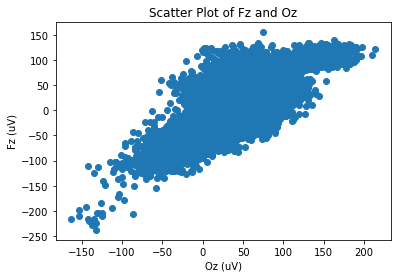

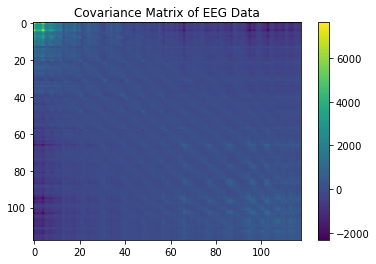

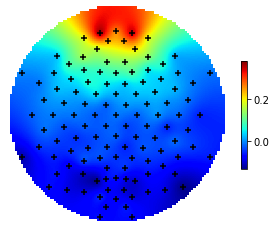

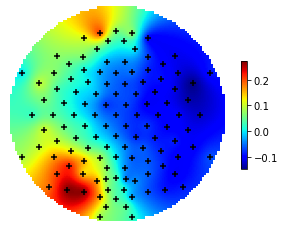

In [3]:
# vreating dictionary of channels
period = 1/float(fs)
max_t = X.shape[1] / float(fs)
t = np.arange(0, max_t, period)

c_lbl = {}

for i in range(len(clab)):
    c_lbl[clab[i]] = i

fz = X[c_lbl['Fz']]
oz = X[c_lbl['Oz']]

#data_nd = X.
#fig, ax = plt.subplots(3,1)

plt.scatter(oz, fz)
plt.ylabel('Fz (uV)')
plt.xlabel('Oz (uV)')
plt.title('Scatter Plot of Fz and Oz')
plt.show()

X = X - np.mean(X, axis=0)
# print('mean of Fz: {}'.format(np.mean(fz)))
# print('mean of Oz: {}'.format(np.mean(oz)))

covar = np.cov(X)

plt.imshow(covar, aspect='auto')
plt.title('Covariance Matrix of EEG Data')
plt.colorbar()
plt.show()

e_val, e_vec = np.linalg.eigh(covar) #returning eigen vector & values with ascending order

#foz_mnt = np.vstack((montage['Fz'], montage['Oz']))
evec_1 = e_vec[:,-1].reshape((-1,1))
evec_2 = e_vec[:,-2].reshape((-1,1))

bci.scalpmap(mnt, evec_1)
plt.show()
bci.scalpmap(mnt, evec_2)
plt.show()

## Exercise 2: Artifact Correction with PCA  (3 points)
Using the backward model, estimate the source activity corresponding to the two components that were found in Ex. \#01 and plot the two obtained time series. Using the forward model, estimate that part of the measured EEG signals, that originates from these two sources. Subtract this multivariate signal from the original EEG. Compare the thus obtained cleaned signal in channel Fz with the original data.

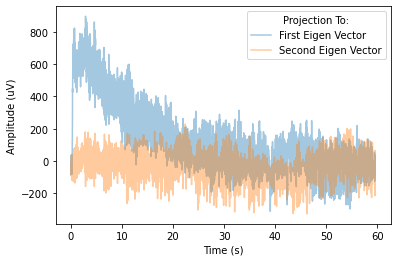

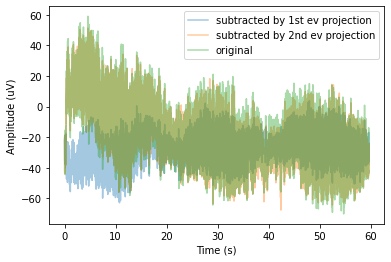

In [4]:
#apply backward model

projected_1 = evec_1.T @ X 
projected_2 = evec_2.T @ X

plt.plot(t, projected_1.T,label='First Eigen Vector', alpha=0.4)
plt.plot(t, projected_2.T,label='Second Eigen Vector', alpha=0.4)
plt.legend(title='Projection To:')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.show()

#apply forward model
x_1 = evec_1 @ projected_1 
x_2 = evec_2 @ projected_2

subtracted_1 = X - x_1
subtracted_2 = X - x_2

plt.plot(t, subtracted_1[c_lbl['Fz']], alpha=0.4, label='subtracted by 1st ev projection')
plt.plot(t, subtracted_2[c_lbl['Fz']], alpha=0.4, label='subtracted by 2nd ev projection')
plt.plot(t, X[c_lbl['Fz']], alpha=0.4, label='original')
#plt.xlim(0,100)
#plt.ylim(-60,60)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.show()

## Exercise 3: PCA on band-pass filtered data (3 points)
Design a butterworth band-pass filter of order 10 with the frequency band 8-12 Hz (function `sp.signal.butter`). Apply that band-pass filter to the original EEG signals (function `sp.signal.lfilter`) and compare raw and filtered signals for channel Oz.
Visualize the covariance matrix of the filtered data and check the eigenvalue spectrum, to determine how many strong principal components there are. Visualize those principal components as in Ex. \#01. Compare the results and discuss shortly.

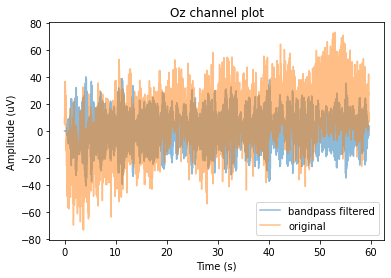

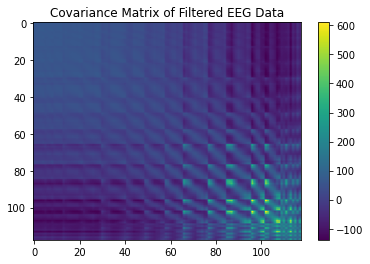

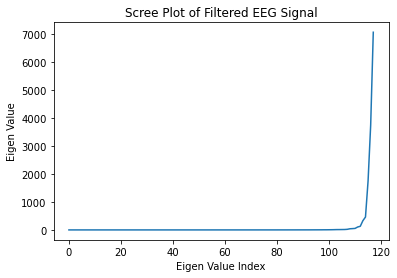

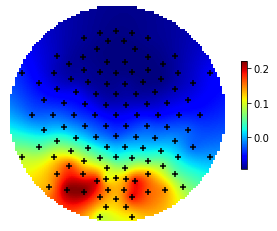

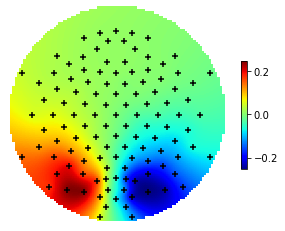

In [7]:
b,a = sp.signal.butter(10, [8,12], btype='bandpass', fs=fs)
y = sp.signal.lfilter(b, a, X, axis=1)

plt.plot(t, y[c_lbl['Oz']], label='bandpass filtered', alpha=0.5)
plt.plot(t, X[c_lbl['Oz']], label='original', alpha=0.5)

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.title('Oz channel plot')
plt.show()

covar_f = np.cov(y)

plt.imshow(covar_f, aspect='auto')
plt.title('Covariance Matrix of Filtered EEG Data')
plt.colorbar()
plt.show()

e_valf, e_vecf = np.linalg.eigh(covar_f) #returning eigen vector & values with ascending order

plt.plot(e_valf)
plt.xlabel('Eigen Value Index')
plt.ylabel('Eigen Value')
plt.title('Scree Plot of Filtered EEG Signal')
plt.show()

evecf_1 = e_vecf[:,-1].reshape((-1,1))
evecf_2 = e_vecf[:,-2].reshape((-1,1))

bci.scalpmap(mnt, evecf_1)
plt.show()
bci.scalpmap(mnt, evecf_2)
plt.show()

Discussion:

From the time series plot, It is clear that the band pass filter remove the dc component of the signal. It should also remove the higher frequency ( > 12 Hz) although it is hardly seen. 

Looking at the covariance matrix, the bandpass filter succesfully remove the the covariance for the first numbers of signal(top left components on the covariance plot).

The scalp plot shows significant improvement. The unfiltered eigen vector is mostly focused on the front of the scalp. However after filtering, the highest eigne component now are whifted to the back of the scalp. The second eigen vector also changes in rather modest amount.

## Exercise 4: Reconstruction with few PCs  (2 points)
Calculate the signals corresponding to the strongest principal components (second part of Ex. \#03) of the filtered data (project EEG data onto the PCs, i.e. go from *sensor space* to *source space*). Then reconstruct the EEG data from those strong principal components, i.e. project the signals obtained in the first step back into *sensor space*. Compare the band-pass filtered signal with the reconstructed signal in channel Oz. For plotting, the first six seconds are enough. You can also apply an error measure on your choice.

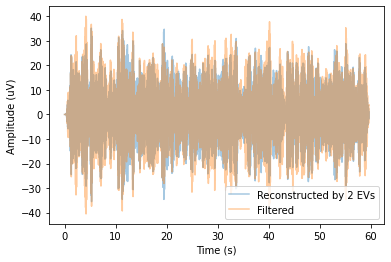

mse error: 25.921870919780762


In [12]:
evecsf = e_vecf[:,-2:]
#apply backward model

projectedf = evecsf.T @ y

#apply forward model
xf = evecsf @ projectedf 

#subtractedf = y - xf

plt.plot(t, xf[c_lbl['Oz']], alpha=0.4, label='Reconstructed by 2 EVs')
plt.plot(t, y[c_lbl['Oz']], alpha=0.4, label='Filtered')
#plt.xlim(0,100)
#plt.ylim(-60,60)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.show()

mse_error = np.mean(np.square(y-xf))
print('mse error: {}'.format(mse_error))